# CS145: Project 2 | How to Get Away with Crime (SF Edition)

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Gaby Cortes, gcrt0701*
* *Lance Allan, lallan*

# Project Overview

---
Crime in San Francisco has increasingly made its way into the spotlight as homelessness continues to be a large issue afflicting the city and Bay Area more generally. On a greater scale, San Francisco is also being seen as on a decline because post-pandemic, more work is becoming remote and up to 30% of office space is now vacant in the city, up from 9.5%.


As crime and homelessness on the streets contributes to this positive cycle, in this investigation we aim to answer our question, "What are the spatial and temporal patterns of crime in San Francisco?" We hope to find geographical and temporal spots with low crime resolutions rates to determine the best times to commit a crime without consequence and become San Francisco's new biggest criminal.


Therefore, we will use the following subquestions to guide our investigation:
- How do resolution rates change over time?
- What days of the week have high crime resolution rates?
- What months are there low resolution rates?
- In what locations is crime most prevalent, and where does it get resolved most often?

---


# Analysis of Dataset

## Raw Dataset Summary
Our dataset for this project consists of four raw tables, listed as follows:
- `sfpd_incident_reports_2003_2018` (394.07 MB | 2,129,525 rows): Publicly available information about police department incident reports from 2003 to May 2018.
- `sfpd_incident_reports_2018_present` (149.84 MB | 176,456 rows): Publicly available information about police department incident repots from 2018 to present day.
- `sf_census_population` (512 B | 32 rows): US Census data of the population per year in San Francisco County.
- `sf_pop_by_police_district_2020` (175 B | 10 rows): Population per SFPD district in 2020.

Raw Dataset Size: 543.91 MB

### Police Department Incident Reports: Historical 2003 to May 2018
This is by far, the largest table of the dataset and the one who's schema we will be trying to conform to the most. The primary key of this table is the `PdID` (int), which functions as a unique identifier for use in update and insert operations. The rest of the columns in the table are summarized as follows:
- `incident_num`(int): Number used to reference multiple reports that belong to the same incident.
- `incident_code`(int), `category`(str), `descript`(str): Details regarding the specifics of the incident that was reported.
- `resolution`(str): Resolution of the incident at the time of report.
- `day_of_week`(str), `date`(date), `time`(str): Temporal descriptors of the incident.
- `pd_district`(str), `address`(str), `x`(float), `y` (float), `location`(str): Spatial descriptors of the incident.



### Police Department Incident Reports: 2018 to Present
This table contains more recent reports but is insufficiently large on its own. It also follows a much more detailed schema from which we had to shed columns to match the historical reports prior to 2018. The following columns were removed with a brief explanation prior to exploration:
- Repetitive: `incident_datetime`, `incident_id`
- No equivalent: `report_datetime`, `cad_number`, `report_type_code`, `report_type_description`, `filed_online`, `incident_subcategory`, `cnn`, `analysis_neighborhood`, `supervisor_district`, `supervisor_district_2012`

The primary key of this table is the `RowID` (int), which functions as a unique identifier for use in update and insert operations. The rest of the columns in the table are summarized as follows:
- `incident_number`(int): Number used to reference multiple reports that belong to the same incident.
- `incident_code`(int), `incident_category`(str), `incident_description`(str): Details regarding the specifics of the incident that was reported.
- `resolution`(str): Resolution of the incident at the time of report.
- `incident_day_of_week`(str), `incident_date`(date), `incident_time`(str), `incident_year`: Temporal descriptors of the incident.
- `police_district`(str), `intersection`(str), `latitude`(float), `longitude` (float), `point`(str): Spatial descriptors of the incident.

### US Census Yearly Population Data for San Francisco County
This table contains yearly values for the population in San Francisco County. This will allow us to normalize the data from year to year to determine whether there has been an increase in the crime rate per 100,000 people. The primary key is `year`(int) and the corresponding value is `sf_pop`(int).

### Population per Police Department District in 2020
This table contains information about the population in each police district in 2020. It was hand-made, referring to the data provided by the Prison Policy Initiative (https://www.prisonpolicy.org/origin/ca/2020/sanfrancisco_police.html). It will similarly allow us to normalize the data across districts in 2020 to determine if there has been a change in the crime rate per 100,000 people. Ideally, we would be able to access data for years other than 2020, but we were not able to find these values. The primary key is `police_district`(str) and the corresponding value is `2020_pop`(int).

## Table Inconsistencies and Deficiencies
As part of this project, we will combine the Police Department Incident Reports Tables into a singular table that spans from 2003 to present. However, this requires us to combine various categories and resolutions into broader groups (the specifics will be discussed further below). During this process, we discovered inconsistencies within each table such as redundant categories (e.g., "Human Trafficking (A), Commercial Sex Acts" and "Human Trafficking, Commercial Sex Acts"). We also encountered categories that were difficult to decipher or not specific enough to categorize the incident as a crime (e.g., "Non-Criminal", "Other", "Suspicious", "Bad Checks"). Across the tables, we also identified discrepancies in resolutions, where the old table includes resolutions related to prosecution and identifies certain cases as psychopathic while the new one does not. We also noticed that every field in either table is marked as `NULLABLE` and identified over 30,000 instances in which a lat-long location is not provided.

More generally, these tables reflect the *publicly available version* of incident reports. It does not contain official crime statistics which are governed by FBI's UCR and NIBRS program rather than the SFPD. It also omits juvenile related data in accordance to California Government Code § 6254 and California Welfare and Institutions Code § 827. The SFPD routinely codifies certain incident reports as confidential for a variety of other reasons as well.

## Relating Tables
To carry out this project's exploration, we combined the two Police Department Incident Reports Tables into a singular table to have sufficient quantity without entirely sacrificing recency. To combine the two tables, we settled on a schema with the following columns:
- `id`(int): Unique identifier for each row (primary key)
- `incident_num`(int): Number used to reference multiple reports that belong to the same incident.
- `incident_code`(int), `category`(str), `descript`(str): Details regarding the specifics of the incident that was reported.
- `resolution`(str): Resolution of the incident at the time of report.
- `day_of_week`(str), `date`(date), `time`(str), `year`(int): Temporal descriptors of the incident.
- `pd_district`(str), `location`(str): Spatial descriptors of the incident.

We combined the two tables via the `UNION` operator since we wanted to append them together to reflect the entirety of 2003 to present. During this operation, we also took the opportunity to exclude categories that were unclear and/or that we deemed non-criminal, not specific enough to categorize the incident as a crime, or not the severity we wanted to consider (e.g., an impounded vehicle due to illegal parking). We also had to remove the 2018 entries from the 2003-2018 table to ensure we weren't double counting any incidents that would already be present in the 2018-present table.

In [ ]:
# Combine datasets and filter out non-criminal incident reports
CREATE TABLE
  `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` AS (
  SELECT
    PdId AS id,
    IncidntNum AS incident_num,
    Incident_Code AS code,
    Category AS category,
    Descript AS descript,
    DayOfWeek AS day_of_week,
    Date AS date,
    Time AS time,
    EXTRACT(YEAR
    FROM
      Date) AS year,
    PdDistrict AS pd_district,
    Resolution AS resolution,
    location
  FROM
    `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_v2`
  WHERE
    EXTRACT(YEAR FROM Date) != 2018
    AND INITCAP(Category) NOT IN ('Case Closure',
      'Fire Report',
      'Miscellaneous Investigation',
      'Recovered Vehicle',
      'Civil Sidewalks',
      'Courtesy Report',
      'Missing Person',
      'Non-Criminal',
      'Offenses Against The Family And Children',
      'Other',
      'Other Miscellaneous',
      'Other Offenses',
      'Suicide',
      'Suspicious',
      'Suspicious Occ',
      'Traffic Collision',
      'Vehicle Impounded',
      'Vehicle Misplaced',
      'Warrant',
      'Bad Checks',
      'Loitering',
      'Pornography/Obscene Mat',
      'Secondary Codes',
      'Warrants')
  UNION ALL (
    SELECT
      Row_ID AS id,
      Incident_Number AS incident_num,
      Incident_Code AS code,
      Incident_Category AS category,
      Incident_Description AS descript,
      Incident_Day_Of_Week AS day_of_week,
      Incident_Date AS date,
      Incident_Time AS time,
      Incident_Year AS year,
      Police_District AS pd_district,
      Resolution AS resolution,
      Point AS location
    FROM
      `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_v1`
    WHERE
      INITCAP(Incident_Category) NOT IN ('Case Closure',
        'Fire Report',
        'Miscellaneous Investigation',
        'Recovered Vehicle',
        'Civil Sidewalks',
        'Courtesy Report',
        'Missing Person',
        'Non-Criminal',
        'Offenses Against The Family And Children',
        'Offences Against The Family And Children',
        'Other',
        'Other Miscellaneous',
        'Other Offenses',
        'Suicide',
        'Suspicious',
        'Suspicious Occ',
        'Traffic Collision',
        'Vehicle Impounded',
        'Vehicle Misplaced',
        'Warrant',
        'Bad Checks',
        'Loitering',
        'Pornography/Obscene Mat',
        'Secondary Codes',
        'Warrants') ) )

## Dataset Summary Post-Processing
After cleaning up our dataset, it consists of three tables, listed as follows:
- `sfpd_incident_reports_combined` (425.44 MB | 1,866,055 rows): Publicly available information about police department incident reports from 2003 to present.
- `sf_census_population` (512 B | 32 rows): US Census data of the population per year in San Francisco County.
- `sf_pop_by_police_district_2020` (175 B | 10 rows): Population per SFPD district in 2020.

Dataset Size: 425.44 MB

# Data Exploration

## Dependencies and Setup

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-projecttwo"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Imports
import matplotlib.pyplot as plt
import plotly.express as px
import json
%matplotlib inline

## Processing Pre-Exploration
Before beginning exploration, we determined that the incident reports would benefit from more broad categorizations of their crime categories and resolutions.

Using the [guidance of Justia](https://www.justia.com/criminal/offenses/), an online platform for the legal community to share their knowledge, we renamed the report categories as subcategories and set the category to one of the following:
- Crimes Against Property
- Violent Crimes
- Statutory Crimes
- Financial Crimes

In [ ]:
# Set category column values based off subcategories
UPDATE
  `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
SET
  category =
  CASE
    WHEN INITCAP(subcategory) IN ('Burglary',
      'Larceny Theft',
      'Lost Property',
      'Malicious Mischief',
      'Motor Vehicle Theft',
      'Motor Vehicle Theft?',
      'Robbery',
      'Stolen Property',
      'Vandalism',
      'Larceny/Theft',
      'Trea',
      'Trespass',
      'Vandalism',
      'Vehicle Theft') THEN 'Crimes Against Property'
    WHEN INITCAP(subcategory) IN ('Arson',
      'Assault',
      'Homicide',
      'Human Trafficking (A), Commercial Sex Acts',
      'Human Trafficking (B), Involuntary Servitude',
      'Human Trafficking, Commercial Sex Acts',
      'Rape',
      'Sex Offense',
      'Weapons Offence',
      'Weapons Offense',
      'Kidnapping',
      'Sex Offenses, Forcible',
      'Sex Offenses, Non Forcible' ) THEN 'Violent Crimes'
    WHEN INITCAP(subcategory) IN ('Drug Offense',
      'Drug Violation',
      'Gambling',
      'Liquor Laws',
      'Prostitution',
      'Traffic Violation Arrest',
      'Weapons Carrying Etc',
      'Disorderly Conduct',
      'Driving Under The Influence',
      'Drug/Narcotic',
      'Drunkenness',
      'Liquor Laws',
      'Weapon Laws' ) THEN 'Statutory Crimes'
    WHEN INITCAP(subcategory) IN ('Embezzlement',
      'Forgery and Counterfeiting',
      'Fraud',
      'Bribery',
      'Extortion',
      'Forgery/Counterfeiting' ) THEN 'Financial Crimes'
  END
WHERE
  subcategory IS NOT NULL

We similarly categorized the various resolutions into a broader `resolution_type` determining whether a resolution was reached and whether there was (or should have been) a consequence. The categories we determined were as follows:
- *No Resolution, Ongoing*: The case is still active and no culprit has been determined.
- *Resolution with Consequence*: A culprit has been identified and faced a consequence (either arrested or prosecuted).
- *Resolution without Consequence*: The case lacked sufficient evidence and was closed.
- *No Consequence Despite Evidenc*e: A culprit has been identified with sufficient evidence, but for something prevented further consequences.

In [ ]:
# Set resolution_type column values
UPDATE
  `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
SET
  resolution_type =
  CASE
    WHEN resolution IN ('Open or Active',
      'NONE',
      'LOCATED',
      'PSYCHOPATHIC CASE' ) THEN 'No Resolution, Ongoing'
    WHEN resolution IN ('Cite or Arrest Adult',
      'ARREST, BOOKED',
      'ARREST, CITED',
      'PROSECUTED BY OUTSIDE AGENCY',
      'PROSECUTED FOR LESSER OFFENSE' ) THEN 'Resolution with Consequence'
    WHEN resolution IN ('Unfounded',
      'UNFOUNDED',
      'DISTRICT ATTORNEY REFUSES TO PROSECUTE',
      'NOT PROSECUTED' ) THEN 'Resolution without Consequence'
    WHEN resolution IN ('Exceptional Adult',
      'EXCEPTIONAL CLEARANCE',
      'COMPLAINANT REFUSES TO PROSECUTE' ) THEN 'No Consequence Despite Evidence'
  END
WHERE
  resolution IS NOT NULL

## Analysis Across San Francisco

### Naive Analysis

To begin our exploreation, we want to identify basic trends in crime year to year. We decided to start off with a naive analysis of the number of incidents reported per year.

In [ ]:
%%bigquery --project $project_id

SELECT year, COUNT(*) AS num_incidents
FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
GROUP BY year
ORDER BY year

Query is running:   0%|          |

Downloading:   0%|          |

,year,num_incidents
0,2003,92400
1,2004,91905
2,2005,90874
3,2006,84734
4,2007,82980
5,2008,84498
6,2009,82892
7,2010,75727
8,2011,74030
9,2012,82625


NameError: ignored

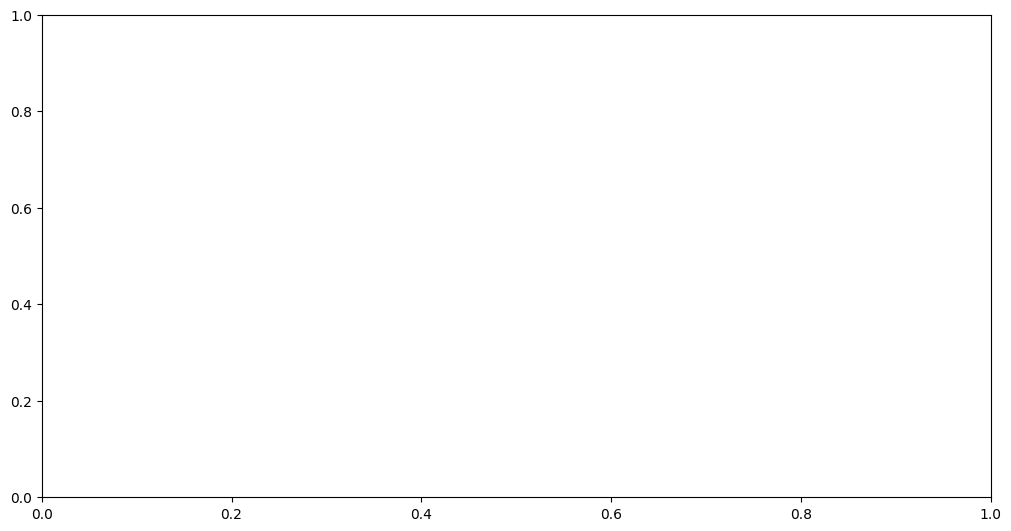

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['num_incidents']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xticks(range(2003, 2024, 2))
plt.xlabel('Year')
_ = plt.ylabel('Number of Incidents')
plt.title('Number of Crime-related Incidents in San Francisco per Year')
plt.text(2003, 93000, '92400', fontsize=9, ha='center')
plt.text(2011, 73000, '74030', fontsize=9, ha='center')
plt.text(2018, 109000, '108424', fontsize=9, ha='center')
plt.text(2022, 100000, '99786', fontsize=9, ha='center')
plt.show();

We observe the number of crime-related incidents across the city has generally fluctuated up and down since 2003. The number of crimes reached an all time low in 2011, potentially due to an increase in [public safety realignment policies](
https://www.bscc.ca.gov/wp-content/uploads/Alameda_County_2011-2012.pdf
) in the state. However, post-2011, crime continued to increase up until a sharp decline in 2020, presumably due to the pandemic. Since then, we have seen a slight increase as crime returns to pre-pandemic levels. As of now, it appears as if 2023 has experienced less crime, although we must keep in mind that it is incomplete.

While it might be easy to assume that crime has generally been increasing from 2003, these numbers are not normalized by the number of people living in San Francisco for any given year. Thus, the incident number may have spiked upwards or downwards due to changes in the city's population. We also don't have any insights as to whether commiting a crime during a peak year or low year is more likely to have consequences.


### Normalized Analysis

In order to normalize the data, we consider the population of San Francisco each year up until 2021 using US Census figures. We then consider the rate of crime-related incidents per year for every 1000 people rather than the raw count.

In [ ]:
%%bigquery --project $project_id

SELECT i.year AS year, ROUND(COUNT(*) / p.sf_pop * 1000, 2) AS incident_rate_1k_people
FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` i
JOIN `cs145-projecttwo.cs_145_sf_crime.sf_census_population` p
ON i.year = p.year
GROUP BY year, p.sf_pop
ORDER BY year

Query is running:   0%|          |

Downloading:   0%|          |

,year,incident_rate_1k_people
0,2003,121.96
1,2004,122.52
2,2005,121.35
3,2006,112.76
4,2007,109.42
5,2008,110.16
6,2009,107.05
7,2010,94.01
8,2011,90.76
9,2012,99.67


NameError: ignored

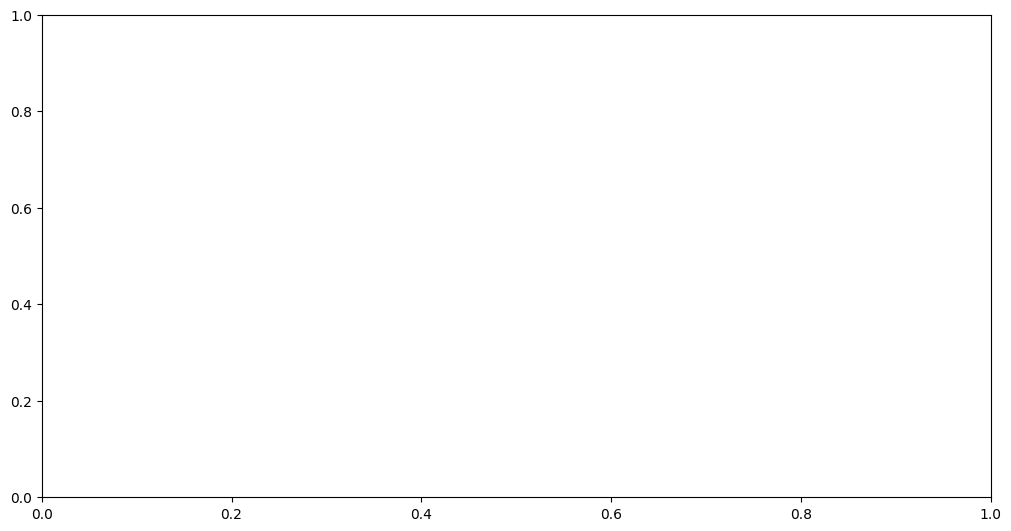

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['incident_rate_1k_people']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_17.sort_values('year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xticks(range(2003, 2022, 2))
plt.xlabel('Year')
_ = plt.ylabel('Incident Rate per 1000 people')
plt.title('Crime-related Incidents Rate in San Francisco per Year')
plt.show();

After normalizing the data to a crime-incident rate for every 1000 people living in San Francisco, we see the rate has remained at or below 2003 levels, ranging from 90 to 125 and averaging around 110 crime-related incidents per thousand people. While we do still see the general upward trend since 2011 in the crime-incident rate as with the raw numbers from the naive analysis, it's important to note we only have population statistics up until 2021, so we cannot compare crime-rate to the raw count for the last two years. Regardless, our main takeaway is that year appears to have an effect on crime density.

-------------------------------------------------------

Next, we are interested in finding trends in crime rates per category over time. We hope to find what crimes are becoming more common in the hopes of perfecting a trendy crime to boost our public image.

In [ ]:
%%bigquery --project $project_id

SELECT i.year, i.category, ROUND(COUNT(*) / p.sf_pop * 1000) AS incident_rate_1k_people
FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` i
JOIN `cs145-projecttwo.cs_145_sf_crime.sf_census_population` p
ON p.year = i.year
GROUP BY i.category, i.year, p.sf_pop
ORDER BY i.year, i.category

Query is running:   0%|          |

Downloading:   0%|          |

,year,category,incident_rate_1k_people
0,2003,Crimes Against Property,78.0
1,2003,Financial Crimes,8.0
2,2003,Statutory Crimes,20.0
3,2003,Violent Crimes,16.0
4,2004,Crimes Against Property,81.0
...,...,...,...
75,2021,None,0.0
76,2021,Crimes Against Property,87.0
77,2021,Financial Crimes,5.0
78,2021,Statutory Crimes,7.0


NameError: ignored

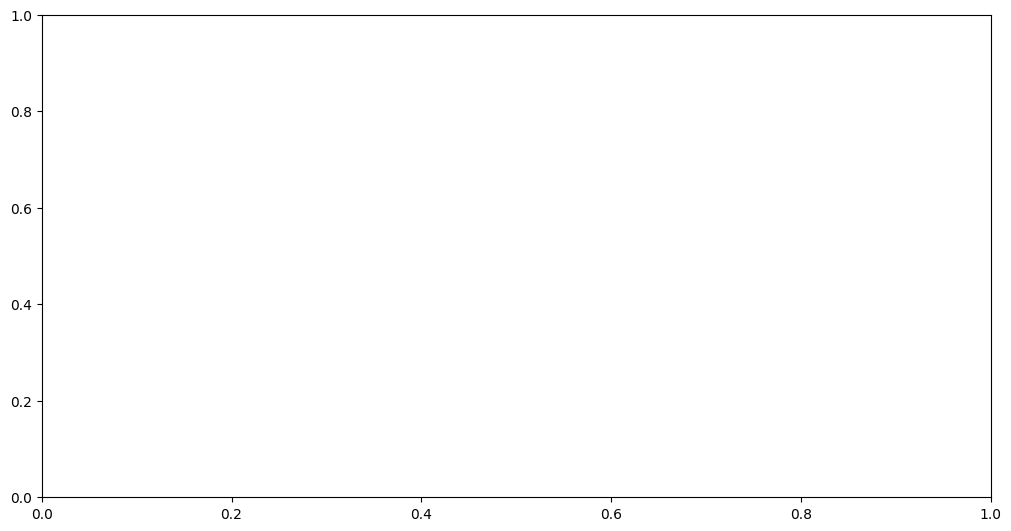

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['num_incidents']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_49.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('category')):
  _plot_series(series, series_name, i)
  fig.legend(title='category', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xticks(range(2003, 2022, 2))
plt.xlabel('Year')
_ = plt.ylabel('Incident Rate per 1000 people')
plt.title('Crime-related Incident Rate by Category in San Francisco per Year')
plt.show();

Crimes against property are by far the most popular type of crime reported in San Francisco, with an incident rate nearly 4 times higher than the other 3 crimes for any given year. Crimes against property have generally been rising since 2011, as we saw with the total crime-incident rate. The other 3 crime rates have remained relatively constant with only a slight downward trend since 2003.

Crimes against property may be the most common because they are the easiest crime to commit skillswise and provide an immediate benefit. Violent crimes, on the other hand, are riskier and require a higher threshold of immorality or circumstance to commit. Statutory crimes, while not difficult to partake in, are potentially less likely to be reported and captured within this dataset since they are often secretive and may not cause any direct harm to another individual. Financial crimes are often white collar crimes and require skill, power, and influence to commit.

-------------------------------------------------------

Here, we want to determine the rate at which a crime is resolved with some sort of consequence (i.e, arrest, citation, or prosecution). As criminals, our utmost priority is getting away with the crime to continue our life of delinquency another day. To do this, we first examine the rate of resolution with consequence as a percentage for every category each year across San Francisco.

In [ ]:
%%bigquery --project $project_id

SELECT i.category, i.year, ROUND(COUNT(*) / c.num, 4) AS rate
FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` i
JOIN (
  SELECT category, year, COUNT(*) AS num
  FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
  GROUP BY category, year) c
ON c.category = i.category AND c.year = i.year
WHERE i.resolution_type = 'Resolution with Consequence'
GROUP BY i.category, i.resolution_type, c.num, i.year
ORDER BY i.year, i.category, i.resolution_type

Query is running:   0%|          |

Downloading:   0%|          |

,category,year,rate
0,Crimes Against Property,2003,0.1297
1,Financial Crimes,2003,0.2118
2,Statutory Crimes,2003,0.9025
3,Violent Crimes,2003,0.3284
4,Crimes Against Property,2004,0.1164
...,...,...,...
79,Violent Crimes,2022,0.2702
80,Crimes Against Property,2023,0.0637
81,Financial Crimes,2023,0.0192
82,Statutory Crimes,2023,0.7705


NameError: ignored

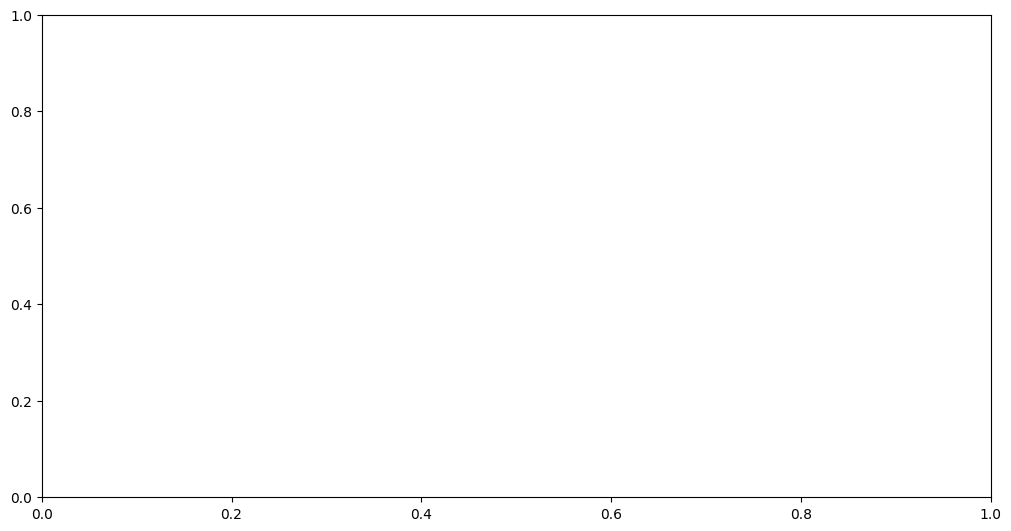

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['rate']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('category')):
  _plot_series(series, series_name, i)
  fig.legend(title='category', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xticks(range(2003, 2024, 2))
plt.xlabel('Year')
_ = plt.ylabel('Resolution with Consequence Rate')
plt.title('Resolution Rate with Consequence Each Year by Crime')
plt.show();

Looking at the graph, statutory crimes that are reported have the highest rate (over 70%) of being resolved with a consequence. Crimes against property typically have the lowest resolution rate (around 15%) likely because the targets are more random. Violent crimes are resolved with consequence at a rate from 30 to 40%, and financial crimes are resolved at a rate of 20% with a steep drop off in 2018. There is generally a decline in the resolution rates of all the crimes as we move closer to the present likely because less time has passed to resolve the crimes, so they remain open or active.

A possible explanation for the trends we observe are that statutory crimes include subcategories such as drug violations, DUI, drunkenness, and weapon laws. There crimes are generally easier to prove guilt than the other crimes and result in immediate arrest. All other crime categories are more complex and require some level of investigation, of which violent crimes are the most severe and urgent to solve.

We can also discern that there isn't a high correlation between resolution rates and crime rates. Crime rate trends are similar to the number of incidents while resolution rates have an inverse relationship with time, generally decreasing as we move closer to the present. However, we do notice a negative relationship in the case of crimes against property as they have the highest crime rate but lowest resolution rates. This pattern may excacerbate itself, as more people realize they can get away with a crime against property without getting caught and go on and commit the crime, contributing to a the problems of a resource-strained SFPD.

Given that, committing a statutory crime is off the table due to its high resolution rate while crimes against property are increasing in appeal.

## Geographical Analysis

Now that we have a general idea of crime and resolution rates across the city, we want to determine the best location to commit a crime. We'll look at the 10 PD Districts across the city since there exists single police force per area.
![image.png](https://img.hoodline.com/uploads/story/image/10247/sfpdfinal.png)

First, we'll start by looking at where the most crime-related incidents have occured using a heat map.

In [ ]:
incident_count_per_district = client.query('''
  SELECT UPPER(pd_district) AS pd_district, COUNT(pd_district) AS num_incidents
  FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
  WHERE UPPER(pd_district) != 'OUT OF SF' AND UPPER(pd_district) != 'NA'
  GROUP BY UPPER(pd_district)
''').to_dataframe()

incident_count_per_district

,pd_district,num_incidents
0,PARK,96642
1,BAYVIEW,163101
2,CENTRAL,239282
3,MISSION,239444
4,TARAVAL,135053
5,NORTHERN,262026
6,RICHMOND,108914
7,SOUTHERN,305561
8,INGLESIDE,149221
9,TENDERLOIN,157834


In [ ]:
import requests
import folium
import geopandas as gpd
import pandas as pd

city_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)
pd_districts = gpd.read_file('Current Police Districts.geojson')

# Add choropleth layer
folium.Choropleth(geo_data = pd_districts,
    data = incident_count_per_district,
    columns = ['pd_district', 'num_incidents'],
    key_on = 'feature.properties.district',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Number of Incidents'
).add_to(city_map)

city_map

Our naive geographical analysis suggests Southern has the highest amount of crime-related incidents followed by Central, Northern, and Mission. Besed on the raw numbers, committing crimes in Southern would be a good way to make a name for ourselves amongst the criminal community.

One thing that stands out is how the Tenderloin district exists in a supposedly high crime area but appears rather 'safe'. This coupled with its pecularly small size amongst districts and it's reputation as a high crime area leads us to think normalizing data by population will reveal a different distribution of crime.

-------------------------------------------------------

Population statistics per district are a very specific and not commonly used metric. Consequently, we were only able to find this information for 2020 which limits our exploration of crime incident-rates per district. However, as mentioned previously, we believe normalizing the data is crucial to our understanding of geographic patterns and opted to complete this query for the single available year.

In [ ]:
incident_rate_per_district_2020 = client.query('''
  SELECT
    UPPER(pd_district) AS pd_district,
    COUNT(*) / p._2020_pop * 1000 AS num_incidents
  FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` i
  JOIN `cs145-projecttwo.cs_145_sf_crime.pop_by_district_2020` p
  ON UPPER(i.pd_district) = UPPER(p.police_district)
  WHERE
    UPPER(pd_district) != 'OUT OF SF'
    AND UPPER(pd_district) != 'NA'
    AND year = 2020
  GROUP BY UPPER(pd_district), p._2020_pop
''').to_dataframe()
incident_rate_per_district_2020

,pd_district,num_incidents
0,PARK,71.715225
1,BAYVIEW,102.622977
2,CENTRAL,149.680207
3,MISSION,119.313598
4,TARAVAL,36.462729
5,NORTHERN,123.425790
6,RICHMOND,68.665520
7,SOUTHERN,139.507026
8,INGLESIDE,51.810201
9,TENDERLOIN,184.955777


In [ ]:
city_map_2020_rates = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

folium.Choropleth(geo_data = pd_districts,
    data = incident_rate_per_district_2020,
    columns = ['pd_district', 'num_incidents'],
    key_on = 'feature.properties.district',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Number of Incidents'
).add_to(city_map_2020_rates)

city_map_2020_rates

After normalizing the crime-incident rate per district, we find that indeed the raw numbers were unrepresentative of crime report density. We find that the Tenderloin district has the most crime per 1000 residents. The more general trend is that of a higher crime-incident rate as we move North and East, likely because those areas are closer to Downtown.

Thus, we may want to begin committing crime in the Tenderloin to build raport and recruit a sidekick, before eventually expanding in to Taraval and Ingleside where we might have a bigger impact and visibility due to lower rates.

-------------------------------------------------------

We are now looking for PD Disrticts with the lowest resolution with consequence rates so we have the best chance of getting away with crime.

In [ ]:
incident_resolution_rate_per_district = client.query('''
  SELECT
    UPPER(i.pd_district) AS pd_district,
    ROUND(COUNT(*) / c.num, 4) AS rate
  FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` i
  JOIN (
    SELECT UPPER(pd_district) as pd_district, COUNT(pd_district) AS num
    FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
    GROUP BY UPPER(pd_district)) c
  ON c.pd_district = UPPER(i.pd_district)
  WHERE
    UPPER(i.pd_district) != 'OUT OF SF'
    AND UPPER(i.pd_district) != 'NA'
    AND i.resolution_type = 'Resolution with Consequence'
  GROUP BY UPPER(i.pd_district), c.num
''').to_dataframe()
incident_resolution_rate_per_district

,pd_district,rate
0,PARK,0.1765
1,BAYVIEW,0.1967
2,CENTRAL,0.1561
3,MISSION,0.2870
4,TARAVAL,0.1432
5,NORTHERN,0.1613
6,RICHMOND,0.1122
7,SOUTHERN,0.2346
8,INGLESIDE,0.1622
9,TENDERLOIN,0.5173


In [ ]:
city_map_resolution_rates = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Add choropleth layer
folium.Choropleth(geo_data = pd_districts,
    data = incident_resolution_rate_per_district,
    columns = ['pd_district', 'rate'],
    key_on = 'feature.properties.district',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Number of Incidents'
).add_to(city_map_resolution_rates)

# Save the map as an HTML file or display it
city_map_resolution_rates


Although the Tenderloin has the highest crime rate, it also has the highest resolution rate (almost double that of the next district), likely due to increased policing. Central district, on the other hand, has the second highest crime incident rate, yet its resolution rates are among the lowest in the city. We also oberserve when factoring in the PD districts, that resolution rates and crime rates aren't very correlated again, leading us to believe we can remove crime rates from our prediction model later in the investigation.

We might want to avoid commiting crimes in the Tenderloin to avoid getting caught before committing our final crime. Instead, Central may be the ideal site for practice and recruitment.

-------------------------------------------------------

Lastly, we'll look at resolution rates with consequence by category per district to aid us in determining which types of crimes to commit.

In [ ]:
def get_resolution_rate_query(crime_type):
  return f'''
    SELECT
      UPPER(i.pd_district) AS pd_district,
      ROUND(COUNT(*) / c.num, 4) AS rate
    FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` i
    JOIN (
      SELECT UPPER(pd_district) as pd_district, COUNT(*) AS num
      FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
      WHERE category = '{crime_type}'
      GROUP BY UPPER(pd_district)) c
    ON c.pd_district = UPPER(i.pd_district)
    WHERE
      UPPER(i.pd_district) != 'OUT OF SF'
      AND UPPER(i.pd_district) != 'NA'
      AND i.resolution_type = 'Resolution with Consequence'
      AND category = '{crime_type}'
    GROUP BY UPPER(i.pd_district), c.num, i.resolution_type
  '''

violent_crime_query = get_resolution_rate_query("Violent Crimes")
violent_crime_resolution_rate_per_district = client.query(violent_crime_query).to_dataframe()

property_crime_query = get_resolution_rate_query("Crimes Against Property")
property_crime_resolution_rate_per_district = client.query(property_crime_query).to_dataframe()

financial_crime_query = get_resolution_rate_query("Financial Crimes")
financial_crime_resolution_rate_per_district = client.query(financial_crime_query).to_dataframe()

statutory_crime_query = get_resolution_rate_query("Statutory Crimes")
statutory_crime_resolution_rate_per_district = client.query(statutory_crime_query).to_dataframe()

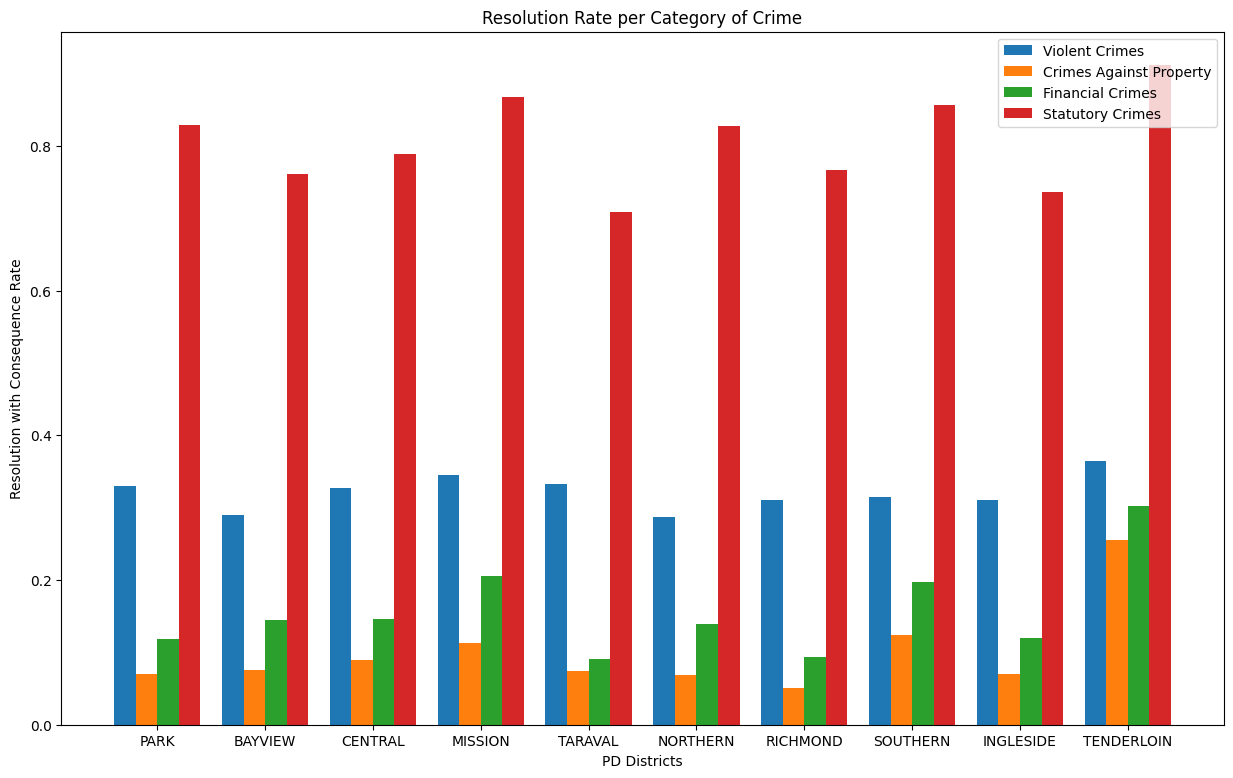

In [ ]:
import numpy as np

# Sample data
pd_districts = list(violent_crime_resolution_rate_per_district.pd_district)
violent_crimes = list(violent_crime_resolution_rate_per_district.rate)
property_crimes = list(property_crime_resolution_rate_per_district.rate)
financial_crimes = list(financial_crime_resolution_rate_per_district.rate)
statutory_crimes = list(statutory_crime_resolution_rate_per_district.rate)

# Set up the bar positions
bar_width = 0.2  # Adjust as needed
index = np.arange(len(pd_districts))

# Plot the bars
plt.figure(figsize=(15, 9))
plt.bar(index - bar_width, violent_crimes, width=bar_width, label='Violent Crimes')
plt.bar(index, property_crimes, width=bar_width, label='Crimes Against Property')
plt.bar(index + bar_width, financial_crimes, width=bar_width, label='Financial Crimes')
plt.bar(index + 2*bar_width, statutory_crimes, width=bar_width, label='Statutory Crimes')

plt.xlabel('PD Districts')
plt.ylabel('Resolution with Consequence Rate')
plt.title('Resolution Rate per Category of Crime')
plt.xticks(index + bar_width / 2, pd_districts)
plt.legend()
plt.show()

We once again see that crimes against property often encounter the lowest rate of resolution with consequence. Richmond and Taraval present an exception to this trend and instead see financial crimes having the lowest rate of resolution. Violent crimes tend to have a resolution rate of around 25%, while statutory crimes beat out all other categories at a whopping 70-80%. These rates appear to match the patterns we saw in our city-wide analysis and thus have the same explanations.

Interestingly enough, we see that the Tenderloin does not appear to have resolution rates that are drastically higher than the rest of the districts as we saw above. This may imply that the crime demographic of the Tenderloin consists of a higher percentage of statutory crimes than other districts, thus racing its general resolution rate performance.


Continuing our focus on Central from the previous query, resolution rates for crimes against property are about 5%, among the lowest in the city. All other categories have about average resolution rates compared to the other PD districts.

After analyzing the district patterns, we now know to relocate our activities to Northern in the case that a trusted sidekick betrays us. Northern has the lowest resolution rate for violent crime (around 25%), and thus would be the least risky PD district to exact revenge.

Our main takeaway for this section is we observe that the PD district a crime was committed in and the category of crime have an impact on resolution rates.

## Time Series Analysis

To plan out a successful career, we must also consider temporal patterns to decide which days are the safest to commit our crimes. We will explore different decision paths including day of week and specific dates. We start by determining the resolution rates by day to determine the days with the lowest risk of a consequence.

In [ ]:
%%bigquery --project $project_id

SELECT i.day_of_week, ROUND(COUNT(*) / c.num, 4) AS rate
FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` i
JOIN (
  SELECT day_of_week, COUNT(*) AS num
  FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
  GROUP BY day_of_week) c
ON c.day_of_week = i.day_of_week
WHERE i.resolution_type = 'Resolution with Consequence'
GROUP BY day_of_week, c.num
ORDER BY
  CASE
    WHEN day_of_week = 'Monday' THEN 1
    WHEN day_of_week = 'Tuesday' THEN 2
    WHEN day_of_week = 'Wednesday' THEN 3
    WHEN day_of_week = 'Thursday' THEN 4
    WHEN day_of_week = 'Friday' THEN 5
    WHEN day_of_week = 'Saturday' THEN 6
    WHEN day_of_week = 'Sunday' THEN 7
  END

Query is running:   0%|          |

Downloading:   0%|          |

,day_of_week,rate
0,Monday,0.2176
1,Tuesday,0.2333
2,Wednesday,0.2376
3,Thursday,0.2285
4,Friday,0.2011
5,Saturday,0.2030
6,Sunday,0.2099


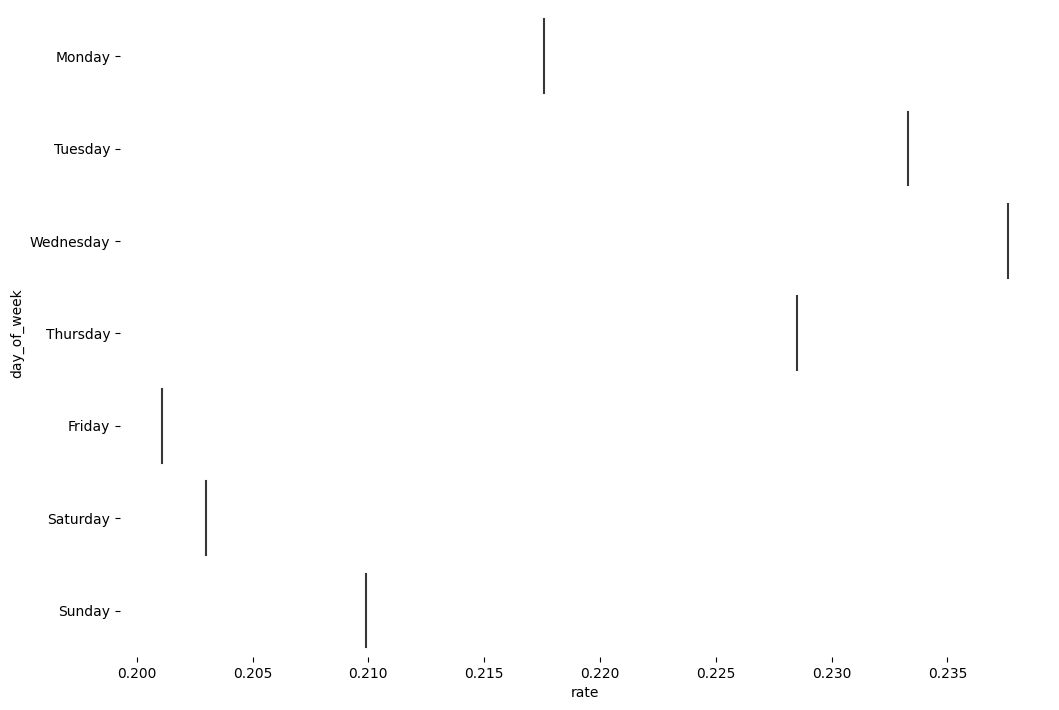

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['day_of_week'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='rate', y='day_of_week', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

We have scaled the graph to better show the differences in resolution rates with consequences. It is important to note the difference between the min and max is only 3.5% and there is likely not a significant explanation for the slight discrepancy in resolution rates. Regardless, we can also take the perspective that there is a 17.5% increase from Friday's resolution rate to Wednesday's. This encourages us to commit a crime on Friday or Saturday over a weekday since we are less likely to face consequences.

Fridays and Saturdays may encounter less resolutions since there may be more reported crime from people being out and about and reduced PD staff due to the weekend.

-------------------------------------------------------

Apart from the day of the week, we can also look at whether the month a crime-related incident occured has an effect on the resolution rate.

In [ ]:
%%bigquery --project $project_id

SELECT EXTRACT(MONTH FROM i.date) AS month, ROUND(COUNT(*) / c.num, 4) AS rate
FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` i
JOIN (
    SELECT EXTRACT(MONTH from date) AS month, COUNT(time_of_day) AS num
    FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
    GROUP BY EXTRACT(MONTH from date)) c
ON EXTRACT(MONTH FROM i.date) = c.month
WHERE resolution_type = 'Resolution with Consequence'
GROUP BY month, c.num
ORDER BY month

Query is running:   0%|          |

Downloading:   0%|          |

,month,rate
0,1,0.2305
1,2,0.2351
2,3,0.2301
3,4,0.2219
4,5,0.2214
5,6,0.2064
6,7,0.2107
7,8,0.2158
8,9,0.2168
9,10,0.2129


We see there is little change in the resolution rate from month to month, with the calculated standard devation being about ~0.9% and a mean of 21.85%. In other words, most of the data lies within about a percent (plus or minus) from the mean. Depending on our remaining features, this may be the weakest metric for determining differences in resolution rates.

-------------------------------------------------------

Next, we move our attention to whether seasons have an effect on the resolution rate. We need to add a new column to our 'combined' dataset called season, with the work shown below.

In [ ]:
# Set season column values based off date

UPDATE
  `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
SET
  season =
  CASE
    WHEN EXTRACT(MONTH FROM date) IN (1, 2, 12)  THEN 'Winter'
    WHEN EXTRACT(MONTH FROM date) BETWEEN 3 AND 5  THEN 'Spring'
    WHEN EXTRACT(MONTH FROM date) BETWEEN 6 AND 8  THEN 'Summer'
    WHEN EXTRACT(MONTH FROM date) BETWEEN 9 AND 11  THEN 'Autumn'
  END
WHERE
  date IS NOT NULL

In [ ]:
%%bigquery --project $project_id

SELECT i.season, ROUND(COUNT(*) / c.num, 4) AS rate
FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` i
JOIN (
    SELECT season, COUNT(season) AS num
    FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
    GROUP BY season) c
ON i.season = c.season
WHERE resolution_type = 'Resolution with Consequence'
GROUP BY i.season, c.num
ORDER BY
  CASE
    WHEN i.season = 'Winter' THEN 1
    WHEN i.season = 'Spring' THEN 2
    WHEN i.season = 'Summer' THEN 3
    WHEN i.season = 'Autumn' THEN 4
  END

Query is running:   0%|          |

Downloading:   0%|          |

,season,rate
0,Winter,0.2242
1,Spring,0.2245
2,Summer,0.2111
3,Autumn,0.2148


We again see seasons don't have a big impact on the resolution rate, which makes sense because they were simply a grouping of months that also didn't have a large impact. However, we did expect to see some differences given more violent crime is committed during summer than winter months per [Forbes](https://www.forbes.com/sites/ariannajohnson/2023/07/06/heres-why-warm-weather-causes-more-violent-crimes-from-mass-shootings-to-aggravated-assault/#:~:text=The%20report%20found%20violent%20crimes,believed%20that%20heat%20increases%20aggression). This further reinforces what we saw earlier that crime-incident numbers aren't a good metric for estimating resolution rates.

---

We are privy to the knowledge that more crime happens during the day, but violent crimes are more likely to occur at night in big cities according to this US News [article](https://www.usnews.com/news/cities/articles/2019-06-12/study-finds-crime-in-big-cities-is-more-likely-during-the-day). To begin, we will create a new column called 'time_of_day' where we will bucket different ranges of time into morning, afternoon, evening, and night. The details of how we created the boundaries are outlined below:

In [ ]:
# Set time of day column values based off date
UPDATE
  `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
SET
  time_of_day =
  CASE
    WHEN CAST(CONCAT(time, ':00') AS TIME) BETWEEN '05:00:00' AND '11:59:59'  THEN 'Morning'
    WHEN CAST(CONCAT(time, ':00') AS TIME) BETWEEN '12:00:00' AND '16:59:59'  THEN 'Afternoon'
    WHEN CAST(CONCAT(time, ':00') AS TIME) BETWEEN '17:00:00' AND '23:59:59'  THEN 'Evening'
    WHEN CAST(CONCAT(time, ':00') AS TIME) BETWEEN '00:00:00' AND '04:59:59'  THEN 'Night'
  END
WHERE
  date IS NOT NULL

Now we will find look at the resolution rates for the time of day a crime-related incident occured.

In [ ]:
%%bigquery --project $project_id

SELECT i.time_of_day, ROUND(COUNT(*) / c.num, 4) AS rate
FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined` i
JOIN (
    SELECT time_of_day, COUNT(time_of_day) AS num
    FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
    GROUP BY time_of_day) c
ON i.time_of_day = c.time_of_day
WHERE resolution_type = 'Resolution with Consequence'
GROUP BY i.time_of_day, c.num
ORDER BY
  CASE
    WHEN i.time_of_day = 'Night' THEN 1
    WHEN i.time_of_day = 'Morning' THEN 2
    WHEN i.time_of_day = 'Afternoon' THEN 3
    WHEN i.time_of_day = 'Evening' THEN 4
  END

Query is running:   0%|          |

Downloading:   0%|          |

,time_of_day,rate
0,Night,0.2177
1,Morning,0.2250
2,Afternoon,0.2445
3,Evening,0.1982


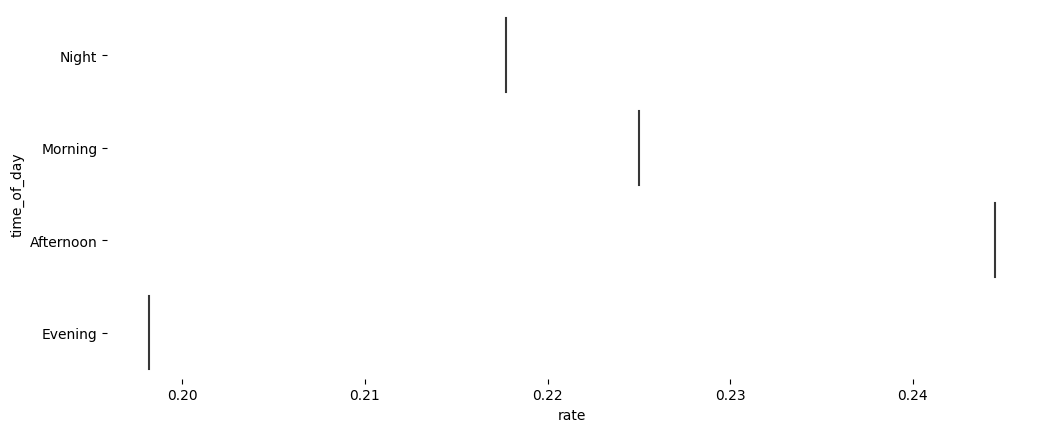

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['time_of_day'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='rate', y='time_of_day', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

We notice a large difference in resolution rates between afternoon and evening of nearly 5%. We also obeserve a negliable difference in resolution rates between morning and night (< 1%) which may be an argument for combining the two. Assuming we did want to commit a violent crime to get revenge on our sidekick (should they betray us), then it seems we would be better off committing the crime in the evening between 5pm and midnight.

---

## Conclusion

As part of our exploration, we have concluded that year, district, and category have strong patterns for crime resolution rates. We observed a slight decline in resolution rates of all crimes in the last decade, identified the Tenderloin as the district with highest resolution rate with its southern neighbors Mission and Southern as the next, and determined that crimes against property are much less likely to face consequences than statutory crime.

Day of the week and time of day have much lower differences but still present a slight correlation of less resolutions with consequences on Fridays and Saturdays and during the evening compared to other alternatives.

The temporal patterns of month and season, on the other hand, had differences of less than 1% among the different values. While this is disappointing and signifies too weak of a pattern to be a feature for our prediction, it presents a simple way to split up our data into training, evaluation, and test sets.

# Baseline and Data Prediction

### K-Nearest Neighbors Baseline

We begin our data prediction by establishing a baseline with a non-machine learning prediction model using a KNN model, where K=5. In other words, we will base our predictions for our data in the evaluation set based on the most common resolution type of the 5 nearest data points in the training set.

We will modify the resolution type to be binary, where the label is set to 1 if there is a resolution with consequence and 0 otherwise. This avoids ties in our prediction and focuses on our main goal as criminals to avoid jail time. The features we will be using for prediction consist of year,  PD district, crime category, day of the week, and time of day.

Since our parameters include both categorical and numerical data, we will use Gower's distance instead of Euclidean. Gower’s distance consists of normalizing the distance between numerical variables to be between 0 and 1 and determining whether categorical variables match (distance of 0) or are different (distance of 1). The computation typically includes the use of different weights for each variable, but for simplicity we will set all the weights to a standard value of 1.

We will use data from the month of September as the evaluation set and August as our test set since we determined earlier in the data exploration that months do not have a large effect on the resolution rates of crime.

In [ ]:
# use knn model to predict the outcome of each datapoint in the evaluation set

knn_predictions = client.query('''
WITH
  # Evaluation Set
  eval_set AS (
    SELECT
      id,
      year,
      pd_district,
      category,
      day_of_week,
      time_of_day,
      CASE
        WHEN resolution_type = 'Resolution with Consequence' THEN 1
        ELSE 0
      END AS label
    FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
    WHERE EXTRACT(MONTH FROM date) = 9
    LIMIT 25000),
  # Training Set
  training_set AS (
    SELECT
      id,
      year,
      pd_district,
      category,
      day_of_week,
      time_of_day,
      CASE
        WHEN resolution_type = 'Resolution with Consequence' THEN 1
        ELSE 0
      END AS label
    FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
    WHERE EXTRACT(MONTH FROM date) != 9 AND EXTRACT(MONTH FROM date) != 8
    LIMIT 200000),
  # Distance from each evaluation point to each training point
  distance AS (
    SELECT
      e.id AS id,
      (((ABS(e.year - t.year) / 20)
      + CAST(e.pd_district != t.pd_district AS INT64)
      + CAST(e.category != t.category AS INT64)
      + CAST(e.day_of_week != t.day_of_week AS INT64)
      + CAST(e.time_of_day != t.time_of_day AS INT64)) / 5) AS gowler_dist,
      t.label AS potential_label  # Label of row in traning data
    FROM eval_set e
    CROSS JOIN training_set t),
  # Sorted distances with ranks per evaluation point
  dist_with_row AS (
    SELECT
      ROW_NUMBER() OVER (PARTITION BY id ORDER BY gowler_dist) AS row,
      id,
      potential_label
    FROM distance
    ),
  # Count per potential label among 5 nearest neighbors per evaluation point
  label_cnt AS (
    SELECT
      id,
      potential_label,
      COUNT(potential_label) cnt
    FROM dist_with_row
    WHERE row <= 5
    GROUP BY id, potential_label)

# Predicting label per evaluation point by using most common potential label
# among 5 nearest neighbors
SELECT
  c.id,
  potential_label AS prediction
FROM label_cnt c
JOIN (
  SELECT id, MAX(cnt) AS max_cnt
  FROM label_cnt
  GROUP BY id
) m
ON c.id = m.id
WHERE c.cnt = m.max_cnt
ORDER BY c.id  # For metrics, not KNN algorithm
''').to_dataframe()

knn_predictions

,id,prediction
0,70953504134,0
1,70953719057,0
2,70954203014,0
3,70955271013,0
4,70958110010,0
...,...,...
24995,18006187306302,0
24996,18017473302020,0
24997,18026269505073,0
24998,18608505709320,0


In [ ]:
# get true labels for each datapoint in the evalutation set

knn_true_labels = client.query('''
  SELECT *
    FROM(SELECT
      id,
      CASE
        WHEN resolution_type = 'Resolution with Consequence' THEN 1
        ELSE 0
      END AS label
    FROM `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
    WHERE EXTRACT(MONTH FROM date) = 9
    LIMIT 25000)
  ORDER BY id  # For metrics
''').to_dataframe()

knn_true_labels

,id,label
0,70953504134,0
1,70953719057,1
2,70954203014,0
3,70955271013,0
4,70958110010,0
...,...,...
24995,18006187306302,0
24996,18017473302020,0
24997,18026269505073,0
24998,18608505709320,0


We have chosen the following performance metrics to evaluate our baseline model:

Accuracy - when your classes are balanced (roughly same number of examples expected for each category)

Recall - when you are more willing to have false positives than false negatives (e.g., predicting rare cancer - you'd rather have a false alarm than miss an actual case)

AUC ROC score - when classes are balanced and you care equally about positive and negative classes. It is a good measure of how well the model separates classes.

We are using accuracy as a general measure of performance, but accuracy is limited by the fact it weights type 1 and type 2 errors equally which is not true in our investigation.

We decided to use recall instead of precision because we are more willing to have false positives than false negatives. Moreover, we'd rather avoid a crime that wouldn't have ended with a consequence than commit a crime we thought would be 'safe' when in reality we'd end up arrested, cited, or prosecuted.

AUC ROC scores provide insight as to how well our model distinguishes positive and negative classes. We will compare that to a baseline of 0.5, which indicates completely random guessing.

In [ ]:
# calculate performance metrics for KNN

import sklearn
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(knn_true_labels.label, knn_predictions.prediction).round(3)
recall = recall_score(knn_true_labels.label, knn_predictions.prediction).round(3)
auc_score = sklearn.metrics.roc_auc_score(knn_true_labels.label, knn_predictions.prediction).round(3)

print(f'Accuracy Score: {accuracy*100}%')
print(f'Recall Score: {recall}')
print(f'ROC AUC Score: {auc_score}')

Accuracy Score: 76.5%
Recall Score: 0.037
ROC AUC Score: 0.5


Our baseline model appears to work well for prediction based on our accuracy score, but as stated earlier we are more concerned with the types of errors in the 23.5% of data we are inaccurately predicting. A low recall score indicates poor performance from the KNN model because we are getting a large number of false negatives which would be a detriment to our crime aspirations. An ROC AUC score of 0.5 suggests our baseline model is no better than random guessing, hence it hasn't improved our understanding of when there are punishments for crime.

### Logistic Regression

We are interested in prediciting whether a crime will result in a resolution with consequence. Thus, the problem is probabilistic in nature and will require a logisitic regression to determine the decision boundaries. We will start by creating the model using the training data, with the hope that a machine learning model will improve performance.

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `cs_145_sf_crime.logistic_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  CASE
    WHEN resolution_type = 'Resolution with Consequence' THEN 1
    ELSE 0
  END AS label,
  year,
  pd_district,
  category,
  day_of_week,
  time_of_day
FROM
  `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
WHERE
  EXTRACT(MONTH FROM date) != 9 AND EXTRACT(MONTH FROM date) != 8

Query is running:   0%|          |

""


Below is some quick information about our training data.

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `cs_145_sf_crime.logistic_model`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,6,0.365491,0.358339,1.6,8945
1,0,5,0.367560,0.360372,6.4,9625
2,0,4,0.372527,0.366209,3.2,8669
3,0,3,0.400331,0.395258,1.6,8549
4,0,2,0.447337,0.443845,0.8,10138
5,0,1,0.515795,0.513871,0.4,8726
6,0,0,0.609137,0.608395,0.2,7308


Now we will evaluate the model using crimes committed in September, as we did with the baseline prediction model.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `cs_145_sf_crime.logistic_model`, (
SELECT
  CASE
    WHEN resolution_type = 'Resolution with Consequence' THEN 1
    ELSE 0
  END AS label,
  year,
  pd_district,
  category,
  day_of_week,
  time_of_day
FROM
  `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
WHERE
  EXTRACT(MONTH FROM date) = 9))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.815573,0.483161,0.864272,0.606827,0.364713,0.832973


We immediately notice a jump in all the performance metrics we were interested in earlier. The accuracy score has increased by almost 10%, the recall score is up 45%, and the ROC AUC score is at a 'good' level of ~0.83, much better than choosing at random. Our linear regression model sees significant improvement over our baseline prediciton model, however there is concern over the low recall score.

## IO Comparison

![image.png](https://docs.google.com/uc?export=download&id=1FiG_1zQD7YALvJ1TVHpqOChhydrYKiKR)


![image.png](https://docs.google.com/uc?export=download&id=1HOV3yeoP6q3ZgJbjXSoHdgV2NSCLDC15)


![image.png](https://docs.google.com/uc?export=download&id=1rrihAh9LNQ05T2SlpiBGXt7_EkTgjdXu)


![image.png](https://docs.google.com/uc?export=download&id=19kePDgsdKNiFNsGcuSIJsXbLvJoeeK3-)

In summary of the work shown above, the KNN algorithm has a 814,139 IO cost for an evaluation set of 25,000 rows and a training set of 200,000 rows. The ML logistic regression model, on the other hand, can train on the entire data set (1,866,055 rows, over 9x bigger) and reuse the computed weights any number of times for an IO cost of 294. This is clear evidence that the ML model scales much better than the KNN baseline, seeing that it is thousands of times cheaper even for larger training sets.

Seeing that the ML model is much more time efficient and beats the KNN model in all our metrics (accuracy, recall, and ROC AUC), the ML model is strictly more effective. We can assume that the monetary cost of training and using the ML model would be lower than that of running the KNN model.

### Prediction

The logistic regression model has not been trained or evaluated on any of the data for the month of August. We will use our test set to predict whether our plan to commit crime will result in a consequence or not to determine the success. We begin by predicting whether our plan of starting in Central to recruit a sidekick will be successful. To reiterate, we will be committing property crimes on Friday evenings in the year 2010 since we have the power to time travel.

In [ ]:
%%bigquery --project $project_id

SELECT
  year,
  pd_district,
  category,
  day_of_week,
  time_of_day,
  predicted_label
FROM
  ML.PREDICT(MODEL `cs_145_sf_crime.logistic_model`, (
SELECT
  year,
  pd_district,
  category,
  day_of_week,
  time_of_day
FROM
  `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
WHERE
  EXTRACT(MONTH FROM date) = 8 AND
  category = 'Crimes Against Property' AND
  day_of_week = 'Friday' AND
  UPPER(pd_district) = 'CENTRAL' AND
  time_of_day = 'Evening' AND
  year = 2010))
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

,year,pd_district,category,day_of_week,time_of_day,predicted_label
0,2010,CENTRAL,Crimes Against Property,Friday,Evening,0
1,2010,CENTRAL,Crimes Against Property,Friday,Evening,0
2,2010,CENTRAL,Crimes Against Property,Friday,Evening,0
3,2010,CENTRAL,Crimes Against Property,Friday,Evening,0
4,2010,CENTRAL,Crimes Against Property,Friday,Evening,0
5,2010,CENTRAL,Crimes Against Property,Friday,Evening,0
6,2010,CENTRAL,Crimes Against Property,Friday,Evening,0
7,2010,CENTRAL,Crimes Against Property,Friday,Evening,0
8,2010,CENTRAL,Crimes Against Property,Friday,Evening,0
9,2010,CENTRAL,Crimes Against Property,Friday,Evening,0


We see that our plan does in fact result in success (getting away with crime) meaning that our predictions from the exploration are correct given the model we trained. We can interpret the results as having high accuracy but what's worrying is the low recall score. Thus, there is a high chance that *if* our prediction is incorrect, then we will be arrested, cited, or prosecuted.

---

In the rare case our sidekick betrayed us, we also want to predict whether or not our plan to exact revenge will be successful or not. In other words, we want to commit a violent crime without any consequence. Our plan is as follows: commit a violent crime in the Northern PD district, on a Saturday evening in the year 2010.

In [ ]:
%%bigquery --project $project_id

SELECT
  year,
  pd_district,
  category,
  day_of_week,
  time_of_day,
  predicted_label
FROM
  ML.PREDICT(MODEL `cs_145_sf_crime.logistic_model`, (
SELECT
  year,
  pd_district,
  category,
  day_of_week,
  time_of_day
FROM
  `cs145-projecttwo.cs_145_sf_crime.sfpd_incidents_combined`
WHERE
  EXTRACT(MONTH FROM date) = 8 AND
  category = 'Violent Crimes' AND
  day_of_week = 'Friday' AND
  UPPER(pd_district) = 'NORTHERN' AND
  time_of_day = 'Evening' AND
  year = 2010))
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

,year,pd_district,category,day_of_week,time_of_day,predicted_label
0,2010,NORTHERN,Violent Crimes,Friday,Evening,0
1,2010,NORTHERN,Violent Crimes,Friday,Evening,0
2,2010,NORTHERN,Violent Crimes,Friday,Evening,0


We observe again that our plan does result in success meaning that our predictions were correct. However, given we are only limited to 3 predicitons, we might consider this crime to be risky considering if we are wrong that

# Conclusion

From our investigation, we have learned that there exists patterns among spatial and temporal features which can predict whether a crime incident in San Francisco will result in a consequence such as arrest, citation, or prosecution with 86% percent accuracy. The specific parameters we focused our model on were:
- time of day, the day of the week, and year a crime happened (temporal)
- the police department jurisdiction of the crime (spatial)
- and the type of crime that was committed.

By doing so, we were able to predict that our master plan of becoming San Francisco’s new biggest criminal and recruiting a sidekick would be successful. However, we did have a low recall score indicating that if our model predicted a false negative, then about half the time it would end up with us in jail. In the case of our plan to exact revenge, we learned that due to a small number of datapoints, we could not be confident that our plan would work out despite all 3 predictions indicating we’d be successful. A limitation of our dataset is we were not able to increase our recall score due to the low number of parameters to choose from.

We also learned that we couldn’t attribute certain spatial and temporal parameters to resolution rates. For example, crime rates per 1000 people - both across SF and by police district - turned out to be a poor metric. We came in expecting that high crime areas were likely more policed and therefore would lead to better resolution rates. Additionally, we expected months and seasons to have an impact on resolution rates since they impacted the number of crime incidents, but we found no such correlation.

On the contrary, certain parameters such as crime type we expected to include as features in our model because certain crimes such as property crimes often have random targets, making it difficult to find evidence to solve. We also expected the police department jurisdiction to have an impact on resolution rates because areas near downtown San Francisco are subject to more crime.

If we had more time, we’d like to check if a crime’s distance from their respective police precinct station would impact the resolution rate since crimes closer to the police might have quicker response times and therefore better resolution rates. We’d also like to investigate how the socioeconomic characteristics of a police district might impact resolution rates, in particular wealth, age, race, and gender. Lastly, we think it would be interesting to study how the socioeconomic background of the assailant might impact resolution rates, but admittedly data of the sort would be difficult to come by since it would not be made publicly available.

Regardless, San Francisco better watch out because the new most successful criminal is about to enter the scene.